# *Algo 3.1 for the top down model*

In [ ]:
%pip install numpy scipy matplotlib

In [1]:
import logging
import numpy as np
from scipy.special import hyp1f1, iv
from scipy.optimize import brentq, minimize_scalar
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import toms748
from scipy.integrate import simpson as simps
from scipy.interpolate import interp1d
from typing import Optional, Tuple, Dict, List
from dataclasses import dataclass
import warnings
import time
import math

ModelParams = Dict[str, float]

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('default_simulation.log')
    ]
)
logger = logging.getLogger(__name__)

@dataclass
class SimulationConfig:
    """Configuration for numerical methods and tolerances"""
    # Numerical methods and tolerances
    # Constants for numerical stability and convergence
    eps_zero: float = 1e-12
    eps_small: float = 1e-8
    # Maximum iterations for numerical methods
    max_iterations: int = 1000
    integration_points: int = 500
    root_finding_maxiter: int = 100
    # Number of grid points for numerical integration and interpolation
    grid_points: int = 500
    # Tolerance for numerical methods
    tolerance_scale: float = 1e-6

config = SimulationConfig()

In [2]:
def validate_parameters(model_params: ModelParams) -> bool:
    """Validate CIR parameters and check Feller condition"""
    try:
        kappa = model_params["kappa"]
        theta = model_params["theta"] 
        sigma = model_params["sigma"]
        
        assert kappa > 0, "kappa must be positive"
        assert theta > 0, "theta must be positive" 
        assert sigma > 0, "sigma must be positive"
        
        feller_condition = 2 * kappa * theta >= sigma**2
        if not feller_condition:
            logger.warning(f"Feller condition violated: 2kappa*theta={2*kappa*theta:.6f} < sigma^2={sigma**2:.6f}")
            
        logger.info(f"Parameters: κ={kappa:.6f}, θ={theta:.6f}, σ={sigma:.6f}")
        logger.info(f"Feller condition {'satisfied' if feller_condition else 'violated'}")
        
        return feller_condition
        
    except Exception as e:
        logger.error(f"Parameter validation failed: {e}")
        raise

In [3]:
def _hyp1f1(a: float, b: float, z: float, method: str = 'primary') -> float:
    """Hypergeometric function evaluation with fallbacks"""
    try:
        # Primary method
        if method == 'primary' and abs(z) < 100 and abs(a) < 50:
            result = hyp1f1(a, b, z)
            if np.isfinite(result) and abs(result) < 1e10:
                return result
        
        # # Fallback for large arguments using series truncation
        # if abs(z) > 100 or abs(a) > 50:
        #     logger.debug(f"Using series approximation for hyp1f1({a:.3f}, {b:.3f}, {z:.3f})")
        #     # For large z, use asymptotic expansion if a is negative integer-like
        #     if a < 0 and abs(a - round(a)) < config.eps_small:
        #         n = int(abs(round(a)))
        #         if n < 20:  # Finite series
        #             result = sum((a + k) * z**k / math.factorial(k) / (b + k) 
        #                        for k in range(n + 1))
        #             return result
        
        # Fallback resort: clip extreme values
        a_clip = np.clip(a, -50, 50)
        z_clip = np.clip(z, -100, 100)
        result = hyp1f1(a_clip, b, z_clip)
        
        if not np.isfinite(result):
            logger.warning(f"hyp1f1 returned non-finite: a={a}, b={b}, z={z}")
            return 1.0  
            
        return result
        
    except Exception as e:
        logger.warning(f"hyp1f1 evaluation failed: {e}, using fallback")
        return 1.0

In [4]:
def hyp1f1_derivative_a(a: float, b: float, z: float, delta: float = None) -> float:
    """Numerical derivative of hypergeometric function"""
    if delta is None:
        delta = max(config.eps_small, abs(a) * config.tolerance_scale)
    
    try:
        f_plus = _hyp1f1(a + delta, b, z)
        f_minus = _hyp1f1(a - delta, b, z)
        derivative = (f_plus - f_minus) / (2 * delta)
        
        if not np.isfinite(derivative):
            # Try smaller delta
            delta *= 0.1
            f_plus = _hyp1f1(a + delta, b, z)
            f_minus = _hyp1f1(a - delta, b, z)
            derivative = (f_plus - f_minus) / (2 * delta)
            
        return derivative if np.isfinite(derivative) else 0.0
        
    except Exception as e:
        logger.warning(f"Derivative computation failed: {e}")
        return 0.0

In [5]:
def laplace_transform_G(H: float, y: float, model_params: ModelParams) -> float:
    """Laplace transform computation"""
    try:
        kappa = model_params["kappa"]
        theta = model_params["theta"]
        sigma = model_params["sigma"]
        
        a = H / kappa
        b = 2 * kappa * theta / sigma**2
        z1 = 2 * kappa * y / sigma**2
        z2 = 2 * kappa * H / sigma**2
        
        logger.debug(f"Laplace transform: a={a:.6f}, b={b:.6f}, z1={z1:.6f}, z2={z2:.6f}")
        
        numerator = _hyp1f1(a, b, z1)
        denominator = _hyp1f1(a, b, z2)
        
        if abs(denominator) < config.eps_zero:
            logger.warning("Near-zero denominator in Laplace transform")
            return 0.99  # Safe fallback
            
        result = numerator / denominator
        
        # Stability check
        # if not (0 <= result <= 1):
        #     logger.warning(f"Laplace transform out of bounds: {result:.6f}")
        #     result = np.clip(result, config.eps_zero, 1 - config.eps_zero)
            
        return result
        
    except Exception as e:
        logger.error(f"Laplace transform failed: {e}")
        return 0.5  # Conservative fallback

In [6]:
def compute_coefficients(y: float, H: float, model_params: ModelParams, n_roots: int = 15) -> Tuple[List[float], List[float]]:
    """Compute eigenfunction expansion coefficients as given by eqn 20 in section 4.2. root finding given in appendix B of the paper"""
    start_time = time.time()
    
    try:
        kappa = model_params["kappa"]
        theta = model_params["theta"]
        sigma = model_params["sigma"]
        
        c_bar = 2 * kappa * theta / sigma**2
        H_bar = 2 * kappa * H / sigma**2
        y_bar = 2 * kappa * y / sigma**2

        if c_bar < 1 or H_bar < c_bar:
            logger.error(f"Invalid parameters: c_bar={c_bar:.6f}, H_bar={H_bar:.6f}, y_bar={y_bar:.6f}")
            return [], []
        
        logger.debug(f"Computing coefficients: c_bar={c_bar:.6f}, H_bar={H_bar:.6f}, y_bar={y_bar:.6f}")
        
        def objective(alpha):
            return _hyp1f1(alpha, c_bar, H_bar)
        
        roots = []
        n = 0
        alpha_prev = 0

        # Find the first root in (-c_bar / H_bar, 0)
        left = -c_bar / H_bar
        right = 0
        try:
            alpha_curr = brentq(objective, left, right)
            roots.append(alpha_curr)
        except Exception as e:
            logger.error(f"Failed to find first root: {e}")
            return [], []

        # Find subsequent roots
        while len(roots) < n_roots:
            n += 1
            # Predict the next root using extrapolation
            alpha_hat = 2 * alpha_curr - alpha_prev

            # Inner loop to bracket the root
            bracket_found = False
            for attempt in range(20):  
                try:
                    test_val = objective(alpha_hat - 1)
                    if np.sign(test_val) == (-1)**n:
                        alpha_hat = alpha_hat - 1
                    else:
                        bracket_found = True
                        break
                except:
                    alpha_hat = alpha_hat - 1
                    if attempt > 10:  # Give up after many attempts
                        break
            
            if not bracket_found:
                logger.warning(f"Could not bracket root {n+1}, stopping at {len(roots)} roots")
                break
                
            try:
                alpha_next = brentq(objective, alpha_hat - 1, alpha_hat)
                roots.append(alpha_next)
                alpha_prev = alpha_curr
                alpha_curr = alpha_next
            except Exception as e:
                logger.warning(f"Failed to find root {n+1}: {e}, stopping at {len(roots)} roots")
                break
        
        if len(roots) < 5:
            logger.error(f"Insufficient roots found: {len(roots)}")
            return [], []
        
        # Compute coefficients
        eta_n, beta_n = [], []
        for alpha in roots:
            try:

                if abs(alpha) <= config.eps_zero:
                    logger.warning(f"Skipping near-zero alpha={alpha:.6f}")
                    eta_n.append(0.0)
                    beta_n.append(0.0)
                    continue
                
                eta = -kappa * alpha
                eta_n.append(eta)
                
                numerator = _hyp1f1(alpha, c_bar, y_bar)
                derivative = hyp1f1_derivative_a(alpha, c_bar, H_bar)
                
                if abs(derivative) < config.eps_zero:
                    logger.warning(f"Near-zero derivative for alpha={alpha:.6f}")
                    beta = 0.0
                else:
                    beta = -numerator / (alpha * derivative)

                if abs(alpha*derivative) < config.eps_small:
                    logger.warning(f"Near-zero product of alpha and derivative for alpha={alpha:.6f}")
                    beta = 0.0
                elif not np.isfinite(beta):
                    logger.warning(f"Non-finite beta for alpha={alpha:.6f}, setting to 0.0")
                    beta = 0.0
                else:
                    beta = -numerator / (alpha * derivative)
                    
                beta_n.append(beta)
                
            except Exception as e:
                logger.warning(f"Coefficient computation failed for alpha={alpha:.6f}: {e}")
                eta_n.append(0.0)
                beta_n.append(0.0)
        
        # Filter out problematic coefficients
        valid_indices = [i for i, (eta, beta) in enumerate(zip(eta_n, beta_n)) 
                        if np.isfinite(eta) and np.isfinite(beta)]
        
        eta_n = [eta_n[i] for i in valid_indices]
        beta_n = [beta_n[i] for i in valid_indices]
        
        logger.debug(f"Computed {len(eta_n)} valid coefficients in {time.time() - start_time:.3f}s")
        
        return eta_n, beta_n
        
    except Exception as e:
        logger.error(f"Coefficient computation failed: {e}")
        return [], []

In [7]:
def compute_survival_probability_p1(y: float, H: float, tau: float, model_params: ModelParams) -> float:
    """Compute survival probability"""
    try:
        eta_n, beta_n = compute_coefficients(y, H, model_params)
        
        if not eta_n:
            logger.warning("No coefficients available, using fallback")
            return 0.5
        
        p1 = sum(beta * np.exp(-eta * tau) for eta, beta in zip(eta_n, beta_n) 
                if np.isfinite(beta) and np.isfinite(eta))
        
        # Stability bounds
        p1 = np.clip(p1, config.eps_zero, 1 - config.eps_zero)
        
        logger.debug(f"Survival probability: {p1:.6f}")
        return p1
        
    except Exception as e:
        logger.error(f"Survival probability computation failed: {e}")
        return 0.5

In [8]:
def cir_transition_density_g(x: float, y: float, t: float, model_params: ModelParams) -> float:
    """CIR transition density computation"""
    try:
        kappa = model_params["kappa"]
        theta = model_params["theta"]
        sigma = model_params["sigma"]
        
        if t <= 0 or x < 0 or y < 0:
            return 0.0
            
        q = (2 * kappa * theta / sigma**2) - 1
        exp_term = np.exp(-kappa * t)
        a = 2 * kappa / (sigma**2 * (1 - exp_term))
        b = a * exp_term
        
        by = b * y + config.eps_zero
        ax = a * x + config.eps_zero
        
        # Compute in log space for stability
        log_factor = np.log(a) - (ax + b * y)
        log_power = (q / 2) * (np.log(ax) - np.log(by))
        
        # Bessel function argument
        bessel_arg = 2 * np.sqrt(a * b * x * y)
        if bessel_arg > 100:  # Use asymptotic approximation
            log_bessel = bessel_arg - 0.5 * np.log(2 * np.pi * bessel_arg)
        else:
            bessel_val = iv(q, bessel_arg)
            if bessel_val <= 0:
                return 0.0
            log_bessel = np.log(bessel_val)
        
        log_density = log_factor + log_power + log_bessel
        
        if log_density > 50:  # Prevent overflow
            return 0.0
            
        return np.exp(log_density)
        
    except Exception as e:
        logger.debug(f"CIR density computation failed: {e}")
        return 0.0

In [9]:
def select_dominating_intensity_H(y: float, model_params: ModelParams, 
                              t_C: float = 1.0, t_eta: float = 1.8, buffer: float = 0.01) -> float:
    """Find optimal threshold H"""
    try:
        theta = model_params["theta"]
        
        H_max = max(y * 3, theta * 2, 1.0)
        H_min = max(y + config.eps_small, theta + buffer, config.eps_small)
        
        def objective(H):
            try:
                G = laplace_transform_G(H, y, model_params)
                
                numerator = H * (t_C + G * t_eta)
                denominator = 1 - G
                
                if denominator < config.eps_zero:
                    return 1e10
                    
                return numerator / denominator
                
            except:
                return 1e10
        
        result = minimize_scalar(objective, method='brent')
        
        if not result.success:
            logger.warning("H optimization failed, using heuristic")
            H_star = max(y * 1.5, theta * 1.2)
        else:
            H_star = result.x
        
        # Apply safety constraints
        H_final = max(H_star, y + config.eps_small, theta + buffer)
        
        logger.debug(f"Optimal H: {H_final:.6f} (y={y:.6f})")
        return H_final
        
    except Exception as e:
        logger.error(f"H optimization failed: {e}")
        return max(y * 1.5, theta * 1.2, 1.0)


In [10]:
def sample_conditional_intensity_from_f(y: float, H: float, tau: float, model_params: ModelParams) -> float:
    """Sample from conditional transition density"""
    try:
        theta = model_params["theta"]
        nu_scale = max(y, theta, 0.1)
        x_max = max(nu_scale * 5, 10.0)  # Reasonable upper bound
        
        n_points = config.integration_points
        x_grid = np.linspace(config.eps_zero, x_max, n_points, endpoint=False)
        
        # Compute transition density
        g_vals = np.array([cir_transition_density_g(x, y, tau, model_params) for x in x_grid])
        
        # Compute convolution integral (simplified for robustness)
        eta_n, beta_n = compute_coefficients(y, H, model_params)
        eta_n = np.array(eta_n)
        beta_n = np.array(beta_n)

        s_grid = np.linspace(0, tau, config.grid_points, endpoint=False)

        def u(s):
            s = np.atleast_1d(s)
            return np.sum(beta_n[:, None] * eta_n[:, None] * np.exp(-eta_n[:, None] * s[None, :]), axis=0)

        
        conv_vals = np.empty_like(x_grid)

        for i, xi in enumerate(x_grid):
            g_shift = np.array([
                cir_transition_density_g(xi, H, tau - sj, model_params)
                for sj in s_grid
            ])
            conv_vals[i] = cumulative_trapezoid(g_shift * u(s_grid), s_grid)[-1]

        p1 = compute_survival_probability_p1(y, H, tau, model_params)
            
        f_vals = (g_vals - conv_vals) / p1
        f_vals = np.clip(f_vals, config.eps_zero, None)  # Avoid negative densities
        f_vals /= np.sum(f_vals)  # Normalize

        if np.sum(f_vals) <= config.eps_zero:
            logger.warning("Sampling failed, using fallback")
            return max(y * np.random.uniform(0.5, 1.5), config.eps_small)
        

        cdf_vals = cumulative_trapezoid(f_vals, x_grid, initial=0)
        # cdf_vals = np.cumsum((f_vals[:-1] + f_vals[1:]) * 0.5 * np.diff(x_grid))
        cdf_vals = np.concatenate(([0.0], cdf_vals))
        total_mass = cdf_vals[-1]
        if total_mass <= 0:
            return y
        cdf_vals /= total_mass

        if cdf_vals[-1] > config.eps_zero:
            cdf_vals /= cdf_vals[-1]
        else:
            # Uniform fallback
            cdf_vals = np.linspace(0, 1, len(cdf_vals))
        
        # Ensure monotonicity
        for i in range(1, len(cdf_vals)):
            cdf_vals[i] = max(cdf_vals[i], cdf_vals[i-1])
        
        # Sample
        u = np.random.uniform()
        try:
            inv_cdf = interp1d(cdf_vals, x_grid, bounds_error=False, 
                             fill_value=(x_grid[0], x_grid[-1]))
            sample = float(inv_cdf(u))
        except:
            # Linear interpolation fallback
            idx = np.searchsorted(cdf_vals, u)
            idx = min(idx, len(x_grid) - 1)
            sample = x_grid[idx]
        
        # Final bounds check
        sample = max(sample, config.eps_small)
        
        logger.debug(f"Sampled intensity: {sample:.6f}")
        return sample
        
    except Exception as e:
        logger.error(f"Conditional sampling failed: {e}")
        return max(y * np.random.uniform(0.8, 1.2), config.eps_small)


In [11]:
def sample_hitting_time_from_v(nu_t: float, H: float, tau: float, model_params: ModelParams) -> float:
    """Sample hitting time"""
    try:
        eta_n, beta_n = compute_coefficients(nu_t, H, model_params)
        
        if not eta_n:
            logger.warning("No coefficients for hitting time, using uniform")
            return np.random.uniform(0, tau)
        
        P = 1 - compute_survival_probability_p1(nu_t, H, tau, model_params)
        P = max(P, config.eps_zero)
        
        U = np.random.uniform(0, P)
        
        def objective(s):
            integral = sum(beta * (1 - np.exp(-eta * s)) for beta, eta in zip(beta_n, eta_n)
                          if eta > config.eps_zero)
            return integral - U

        try:
            result = brentq(objective, 0, tau)
            return min(result, tau)
        except:
            logger.warning("Hitting time root finding failed, using approximation")
            return np.random.uniform(0, tau * 0.8)
            
    except Exception as e:
        logger.error(f"Hitting time sampling failed: {e}")
        return np.random.uniform(0, tau * 0.5)

In [12]:
def sample_loss() -> float:
    """Sample loss from a uniform distribution as per the original model"""
    u = np.random.uniform()
    if u < 0.5:
        return 0.96
    else:
        return 0.24

In [13]:
def simulate_next_default_step(
    t_prev: float,
    lambda_prev: float,
    T_max: float,
    model_params: ModelParams
) -> Optional[Tuple[float, float]]:
    """
    Simulates a single default step in the top-down model.

    Parameters:
        t_prev: float
            Previous default time T_{n-1}
        lambda_prev: float
            Intensity after last jump, λ_{T_{n-1}} 
        T_max: float
            Final time horizon for simulation
        model_params: dict
            Contains CIR and model parameters: kappa, theta, sigma, gamma

    Returns:
        Optional[Tuple[float, float]]:
            If a default occurs before T_max:
                (T_n, ν_{T_n})
            Else:
                None (no more defaults)
    """
    try:
        # STEP 1: Initialize y := λ_{T_{n-1}}, t := T_{n-1}
        y = max(lambda_prev, config.eps_small) # Ensure y is positive
        t = t_prev 
        
        max_inner_iterations = 50  
        
        for iteration in range(max_inner_iterations):
            # STEP 2: Select H>y
            H = select_dominating_intensity_H(y, model_params)
            logger.info(f"Iteration {iteration + 1}: Selected H={H:.6f} for y={y:.6f}")
            
            # STEP 3: Sample τ ∼ Exp(H), propose next interarrival time
            tau = np.random.exponential(1/H)
            logger.debug(f"Sampled interarrival time τ={tau:.6f} from Exp(H) with H={H:.6f}")
            
            # STEP 4: Compute survival probability p1 = P(ν stays below H up to τ)
            p1 = compute_survival_probability_p1(y, H, tau, model_params)
            logger.info(f"Computed survival probability p1={p1:.6f} for y={y:.6f}, H={H:.6f}, τ={tau:.6f}")
            
            # STEP 5: First rejection test with u1 ∼ Unif(0,1)
            u1 = np.random.uniform()
            
            if u1 > p1:
                # Process hits H → sample σ_H from hitting time density
                logger.info(f"Process hits boundary H={H:.6f} at t={t:.6f}, sampling hitting time")
                sigma_H = sample_hitting_time_from_v(y, H, tau, model_params)
                t += sigma_H
                
                # STEP 8: Check if t exceeds T_max
                if t > T_max:
                    return None
                    
                y = H  # Update intensity and repeat
                continue
            else:
                # Process survives to τ
                t += tau
                logger.info(f"Process survives to t={t:.6f}, sampling conditional intensity")
                
                # STEP 8: Check if t exceeds T_max
                if t > T_max:
                    return None
                
                # STEP 6: Sample ν_{T_n} from conditional density f(.; ν_t, H, τ)
                nu_Tn = sample_conditional_intensity_from_f(y, H, tau, model_params)
                logger.debug(f"Sampled conditional intensity ν_{t}={nu_Tn:.6f} at t={t:.6f}")
                
                # STEP 7: Second rejection test using u2 ∼ Unif(0,1)
                u2 = np.random.uniform()
                
                if u2 <= nu_Tn / H:
                    # Accept default at T_n = t
                    # ell_n = sample_loss()  # Draw loss ℓ_n ∼ loss_distribution()
                    
                    # logger.debug(f"Default at t={t:.6f}, ν={nu_Tn:.6f}, loss={ell_n:.6f}")
                    logger.info(f"Default accepted at t={t:.6f}, ν={nu_Tn:.6f}.")
                    return (t, nu_Tn)
                else:
                    # Reject - update ν_t and go back to step 2
                    y = nu_Tn
                    continue
        
        logger.warning(f"Maximum inner iterations reached at t={t:.6f}")
        return None
        
    except Exception as e:
        logger.error(f"Error in simulate_next_default_step: {e}")
        return None

def simulate_defaults(
    lambda_0: float,
    T_max: float,
    model_params: ModelParams,
    max_defaults: int = 1000
) -> List[Tuple[float, float]]:
    """
    Main simulation function that generates a sequence of default times and losses.
    
    Parameters:
        lambda_0: float
            Initial intensity λ_0
        T_max: float
            Time horizon
        model_params: ModelParams
            Dictionary containing kappa, theta, sigma, gamma
        max_defaults: int
            Maximum number of defaults to simulate
            
    Returns:
        List[Tuple[float, float]]: List of (default_time, loss) pairs
    """
    logger.info(f"Starting default simulation: λ_0={lambda_0:.6f}, T_max={T_max:.2f}")
    
    # Validate parameters
    if not validate_parameters(model_params):
        logger.warning("Proceeding despite Feller condition violation")
    
    defaults = []
    t = 0.0
    lam = max(lambda_0, config.eps_small)
    # gamma = model_params.get("gamma", 2.99)  # Default jump size
    gamma = model_params["gamma"]
    start_time = time.time()
    
    try:
        while t < T_max and len(defaults) < max_defaults:
            result = simulate_next_default_step(t, lam, T_max, model_params)
            
            if result is None:
                break
                
            Tn, nu_Tn = result
            ell_n = sample_loss()
            lam = nu_Tn + gamma * ell_n  # Update intensity at default with jump
            t = Tn
            defaults.append((t, lam, ell_n))
            
            if len(defaults) % 10 == 0:
                logger.info(f"Generated {len(defaults)} defaults, t={t:.4f}, λ={lam:.6f}")
        
        elapsed_time = time.time() - start_time
        logger.info(f"Simulation completed: {len(defaults)} defaults in {elapsed_time:.2f}s")
        
        return defaults
        
    except KeyboardInterrupt:
        logger.info("Simulation interrupted by user")
        return defaults
    except Exception as e:
        logger.error(f"Critical simulation error: {e}")
        return defaults

In [ ]:
# paper parameters for testing
model_params = {
    "kappa": 2.62,    # Mean reversion speed
    "theta": 1.61,    # Long-term mean
    "sigma": 0.62,    # Volatility
    "gamma": 0.99     # Jump size multiplier
}

defaults = simulate_defaults(
    lambda_0=0.7,
    T_max=5,
    model_params=model_params,
    max_defaults=100
)

print(f"Generated {len(defaults)} defaults:")
for i, (t, lam, loss) in enumerate(defaults): 
    print(f"  {i+1}: t={t:.6f}, itensity={lam:.6f}, loss={loss:.6f}")


In [ ]:
L = sum(loss for _, _, loss in defaults)
print(f"Total loss: {L:.6f}")

In [ ]:
model_params = {
    "kappa": 2.62,    # Mean reversion speed - from paper
    "theta": 1.61,    # Long-term mean - from paper
    "sigma": 0.62,    # Volatility - from paper
    "gamma": 0.99     # Jump size multiplier - paper's value is 2.99 but we use 0.99 for stability 
    # !TODO: Check why Laplace transform blows up with gamma >~ 1.5. 
    # All further calculations of survival probabilities and sampling from f,v are unstable.
}

L_5 = []

for _ in range(10):
    defaults = simulate_defaults(
        lambda_0=0.7,
        T_max=5,
        model_params=model_params,
        max_defaults=100
    )

    print(f"Generated {len(defaults)} defaults:")
    for i, (t, lam, loss) in enumerate(defaults): 
        print(f"  {i+1}: t={t:.6f}, itensity={lam:.6f}, loss={loss:.6f}")

    l_5 = sum(loss for _, _, loss in defaults)
    print(f"Total loss: {l_5:.6f}")

    L_5.append(l_5)

print(f"Average total loss over 10 runs: {np.mean(L_5):.6f} ± {np.std(L_5):.6f}")



In [ ]:
model_params = {
    "kappa": 2.62,    # Mean reversion speed - from paper
    "theta": 1.61,    # Long-term mean - from paper
    "sigma": 0.62,    # Volatility - from paper
    "gamma": 2.99     # Jump size multiplier 
}

L_5 = []

for _ in range(5):
    defaults = simulate_defaults(
        lambda_0=0.7,
        T_max=5,
        model_params=model_params,
        max_defaults=10
    )

    print(f"Generated {len(defaults)} defaults:")
    for i, (t, lam, loss) in enumerate(defaults): 
        print(f"  {i+1}: t={t:.6f}, itensity={lam:.6f}, loss={loss:.6f}")

    l_5 = sum(loss for _, _, loss in defaults)
    print(f"Total loss: {l_5:.6f}")

    L_5.append(l_5)

print(f"Average total loss over 5 runs: {np.mean(L_5):.6f} ± {np.std(L_5):.6f}")



In [14]:
y =[0.7, 1.0, 1.5, 2.0, 2.5]
model_params = {
    "kappa": 2.62,    # Mean reversion speed - from paper
    "theta": 1.61,    # Long-term mean - from paper
    "sigma": 0.62,    # Volatility - from paper
    "gamma": 0.99     # Jump size multiplier - paper's value is 2.99 but we use 0.99 for stability 
    # !TODO: Check why Laplace transform blows up with gamma >~ 1.5. 
    # All further calculations of survival probabilities and sampling from f,v are unstable.
}
H = [select_dominating_intensity_H(yi, model_params) for yi in y]

import pandas as pd
df = pd.DataFrame({
    'y': y,
    'H': H
})
print("Selected H values for different y:")
print(df)

Selected H values for different y:
     y         H
0  0.7  2.295761
1  1.0  2.362841
2  1.5  2.523985
3  2.0  2.784081
4  2.5  3.152940


In [15]:
laplaces= [laplace_transform_G(Hi, yi, model_params) for Hi, yi in zip(H, y)]

Laplace transforms for different (H, y) pairs:
  y=0.70, H=2.30 => G(H, y)=0.029570
  y=1.00, H=2.36 => G(H, y)=0.027809
  y=1.50, H=2.52 => G(H, y)=0.024280
  y=2.00, H=2.78 => G(H, y)=0.019945
  y=2.50, H=3.15 => G(H, y)=0.015668


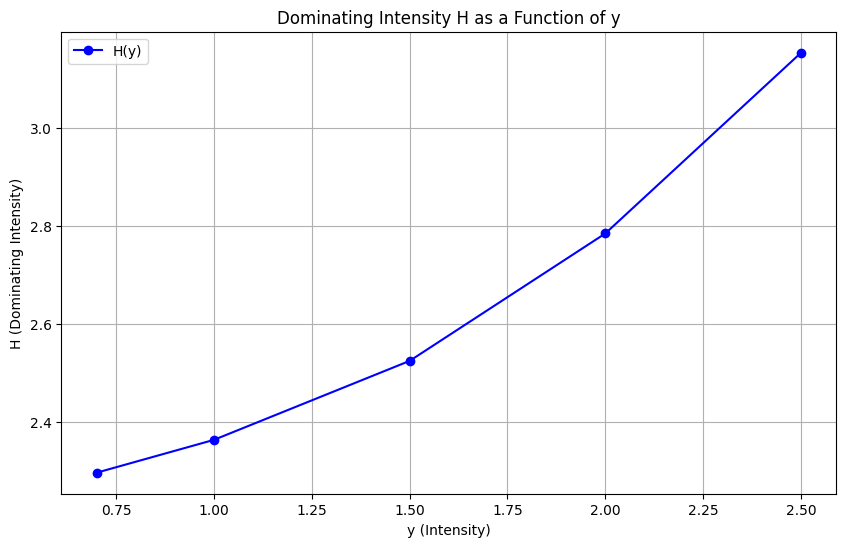

In [16]:
print("Laplace transforms for different (H, y) pairs:")
for yi, Hi, laplace in zip(y, H, laplaces):
    print(f"  y={yi:.2f}, H={Hi:.2f} => G(H, y)={laplace:.6f}")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y, H, marker='o', label='H(y)', color='blue')
plt.title('Dominating Intensity H as a Function of y')
plt.xlabel('y (Intensity)')
plt.ylabel('H (Dominating Intensity)')
plt.grid()
plt.legend()
# plt.savefig('H_vs_y.png')
plt.show()

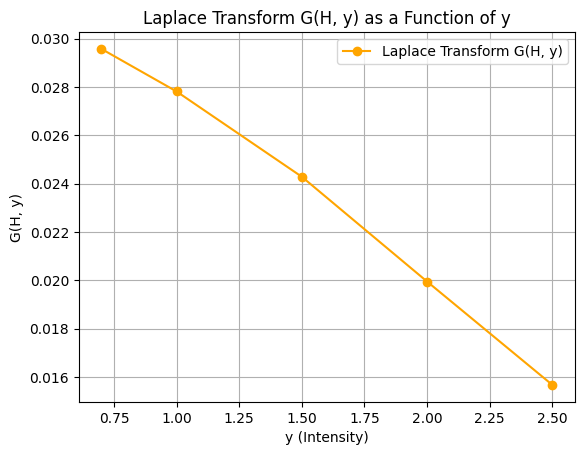

In [17]:
plt.plot(y, laplaces, marker='o', label='Laplace Transform G(H, y)', color='orange')
plt.title('Laplace Transform G(H, y) as a Function of y')
plt.xlabel('y (Intensity)')
plt.ylabel('G(H, y)')
plt.grid()
plt.legend()
plt.show()

In [18]:
# laplace_transform_G(2000, 1950, model_params)
print("Laplace transform:", laplace_transform_G(4.5, 3, model_params))

Laplace transform: 3.91064252675319e-06


In [19]:
select_dominating_intensity_H(3, model_params)

2025-06-13 00:11:42,257 - WARNING - H optimization failed, using heuristic


4.5

In [20]:
rho = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
model_params = {
    "kappa": 2.62,    # Mean reversion speed - from paper
    "theta": 1.61,    # Long-term mean - from paper
    "sigma": 0.62,    # Volatility - from paper
    "gamma": 0.99     # Jump size multiplier - paper's value is 2.99 but we use 0.99 for stability 
    # !TODO: Check why Laplace transform blows up with gamma >~ 1.5. 
    # All further calculations of survival probabilities and sampling from f,v are unstable.
}
kappa = model_params["kappa"]
theta = model_params["theta"]
sigma = model_params["sigma"]
y = [0.7, 1.0, 1.5, 2.0, 2.5]
H = [select_dominating_intensity_H(yi, model_params) for yi in y]
for r, y, H in zip(rho, y, H):
    num = hyp1f1(r/kappa, 2*kappa*theta/sigma**2, 2*kappa*y/sigma**2)
    denom = hyp1f1(r/kappa, 2*kappa*theta/sigma**2, 2*kappa*H/sigma**2)
    laplace = num / denom
    print(f"Laplace transform G(H, y) for ρ={r:.2f}: {laplace:.6f}")

Laplace transform G(H, y) for ρ=0.10: 0.706261
Laplace transform G(H, y) for ρ=0.20: 0.484951
Laplace transform G(H, y) for ρ=0.30: 0.265366
Laplace transform G(H, y) for ρ=0.40: 0.098862
Laplace transform G(H, y) for ρ=0.50: 0.033905


In [21]:
import numpy as np
from scipy.special import hyp1f1
from scipy.optimize import brentq, fsolve
import matplotlib.pyplot as plt

def hypergeom_function(alpha, beta, z):
    """
    Wrapper for the hypergeometric function with error handling
    """
    try:
        return hyp1f1(alpha, beta, z)
    except:
        # Handle overflow or other numerical issues
        return np.inf if alpha > 0 else -np.inf

def find_negative_roots(beta, z, search_range=(-100, 0), num_intervals=100):
    """
    Find negative roots of 1F1(alpha, beta, z) = 0
    """
    # Create a grid to look for sign changes
    alpha_vals = np.linspace(search_range[0], search_range[1], num_intervals)
    func_vals = [hypergeom_function(a, beta, z) for a in alpha_vals]
    
    roots = []
    
    # Look for sign changes to identify bracketing intervals
    for i in range(len(func_vals) - 1):
        if np.sign(func_vals[i]) != np.sign(func_vals[i+1]):
            # Found a sign change, use Brent's method to find the exact root
            try:
                root = brentq(lambda a: hypergeom_function(a, beta, z), 
                            alpha_vals[i], alpha_vals[i+1])
                roots.append(root)
            except ValueError:
                # Brent's method failed, possibly due to numerical issues
                continue
    
    return sorted(roots)

In [22]:
roota = find_negative_roots(2.5, 3.0)
print("Negative roots found:", roota)

Negative roots found: [-89.51100768573906, -73.06181781276186, -58.25761784730814, -45.09843908150232, -33.58433810916113, -23.715425769473054, -15.491942820563954, -8.914489248340779, -3.984842206992805, -0.7079889319685579]


In [23]:
b = 2*1.61*2.62/0.62**2
z = 2*2.97*2.62/0.62**2

roots = find_negative_roots(b, z)

In [24]:
print(roots)

[-98.51292358222916, -93.43552739415861, -88.48064807286868, -83.64835123032287, -78.93871132931062, -74.35181316624112, -69.88775365477244, -65.54664398292437, -61.32861223695691, -57.23380661275024, -53.262399372351766, -49.414591753477694, -45.69062010867602, -42.090763646701426, -38.6153542838733, -35.26478930673021, -32.03954782903138, -28.94021244371708, -25.967498102001137, -23.12229122865221, -20.405703631633582, -17.81914828910322, -15.364448335578196, -13.043997904454399, -10.861006515972667, -8.819882012711743, -6.926845882130835, -5.19091122975252, -3.6251434107262828, -2.2458563038364883, -1.0565478232227021, -0.0047948680479625826]


In [25]:
for root in roots:
    print(f"Value at root {root:.6f}: {hypergeom_function(root, b, z)}")

Value at root -98.512924: -1.5953675892900895e-26
Value at root -93.435527: 1.0993887635161593e-25
Value at root -88.480648: -8.875146608802212e-26
Value at root -83.648351: -1.6339666126764305e-25
Value at root -78.938711: 3.5118300296274435e-25
Value at root -74.351813: 2.6870227758258867e-25
Value at root -69.887754: -1.8762060373929734e-24
Value at root -65.546644: 1.3591992073960766e-22
Value at root -61.328612: -1.0433445154814303e-24
Value at root -57.233807: -4.011622291654675e-24
Value at root -53.262399: 1.3922207138153712e-23
Value at root -49.414592: 1.8832178003536086e-21
Value at root -45.690620: -8.224024747816304e-24
Value at root -42.090764: 5.022063677136091e-23
Value at root -38.615354: 5.697551677086988e-22
Value at root -35.264789: -6.390140419601092e-23
Value at root -32.039548: 4.4598748224652e-22
Value at root -28.940212: 3.8645051802543827e-22
Value at root -25.967498: -1.1982254754568979e-21
Value at root -23.122291: 5.4565410420569575e-21
Value at root -20.40

In [26]:
len(roots)

32

In [27]:
def _hyp1f1(a: float, b: float, z: float) -> float:
    logger.debug(f"Computing hypergeometric function 1F1 with a={a:.6f}, b={b:.6f}, z={z:.6f}")
    return hyp1f1(a, b, z)

In [28]:
def hyp1f1_derivative_a(a: float, b: float, z: float, delta: float = None) -> float:
    """Numerical derivative of hypergeometric function"""
    logger.debug(f"Computing derivative of 1F1 with respect to a={a:.6f}, b={b:.6f}, z={z:.6f}")
    
    if delta is None:
        delta = max(config.eps_small, abs(a) * config.tolerance_scale)
        logger.debug(f"Using delta={delta:.8f} for numerical derivative")
    
    try:
        f_plus = _hyp1f1(a + delta, b, z)
        f_minus = _hyp1f1(a - delta, b, z)
        derivative = (f_plus - f_minus) / (2 * delta)
        
        if not np.isfinite(derivative):
            logger.warning(f"Non-finite derivative detected, reducing delta")
            # Try smaller delta
            delta *= 0.1
            f_plus = _hyp1f1(a + delta, b, z)
            f_minus = _hyp1f1(a - delta, b, z)
            derivative = (f_plus - f_minus) / (2 * delta)
            
        result = derivative if np.isfinite(derivative) else 0.0
        logger.debug(f"Derivative result: {result:.6f}")
        return result
        
    except Exception as e:
        logger.warning(f"Derivative computation failed: {e}")
        return 0.0

In [29]:
def laplace_transform_G(H: float, y: float, model_params: ModelParams) -> float:
    """Laplace transform computation"""
    try:
        kappa = model_params["kappa"]
        theta = model_params["theta"]
        sigma = model_params["sigma"]
        
        a = H / kappa
        b = 2 * kappa * theta / sigma**2
        z1 = 2 * kappa * y / sigma**2
        z2 = 2 * kappa * H / sigma**2
        
        logger.debug(f"Laplace transform: a={a:.6f}, b={b:.6f}, z1={z1:.6f}, z2={z2:.6f}")
        
        numerator = _hyp1f1(a, b, z1)
        denominator = _hyp1f1(a, b, z2)
        
        if abs(denominator) < config.eps_zero:
            logger.warning("Near-zero denominator in Laplace transform")
            return 0.99  # Safe fallback
            
        result = numerator / denominator
        
        # Stability check
        # if not (0 <= result <= 1):
        #     logger.warning(f"Laplace transform out of bounds: {result:.6f}")
        #     result = np.clip(result, config.eps_zero, 1 - config.eps_zero)
            
        return result
        
    except Exception as e:
        logger.error(f"Laplace transform failed: {e}")
        return 0.5  # Conservative fallback

In [30]:
def find_negative_roots(b, z, search_range=(-100, 0), num_intervals=100):
    """
    Find negative roots of 1F1(alpha, b, z) = 0
    """
    logger.debug(f"Finding negative roots of 1F1(alpha, {b:.6f}, {z:.6f}) in range {search_range}")
    
    # Create a grid to look for sign changes
    alpha_vals = np.linspace(search_range[0], search_range[1], num_intervals)
    logger.debug(f"Created grid with {num_intervals} intervals for root finding")
    
    func_vals = [_hyp1f1(a, b, z) for a in alpha_vals]
    
    roots = []
    
    # Look for sign changes to identify bracketing intervals
    for i in range(len(func_vals) - 1):
        if np.sign(func_vals[i]) != np.sign(func_vals[i+1]):
            # Found a sign change, use Brent's method to find the exact root
            try:
                logger.debug(f"Sign change detected between alpha={alpha_vals[i]:.4f} and alpha={alpha_vals[i+1]:.4f}")
                root = brentq(lambda a: _hyp1f1(a, b, z), 
                            alpha_vals[i], alpha_vals[i+1])
                roots.append(root)
                logger.debug(f"Found root at alpha={root:.6f}")
            except ValueError as e:
                logger.warning(f"Brent's method failed for interval [{alpha_vals[i]:.4f}, {alpha_vals[i+1]:.4f}]: {e}")
                continue
    
    logger.info(f"Found {len(roots)} negative roots for 1F1(alpha, {b:.4f}, {z:.4f})")
    return sorted(roots)

In [31]:
def compute_coefficients(y, H, model_params):
    logger.debug(f"Computing series expansion coefficients with y={y:.6f}, H={H:.6f}")
    
    eta_n, beta_n = [], []
    kappa = model_params["kappa"]
    theta = model_params["theta"]
    sigma = model_params["sigma"]

    c_bar = 2 * kappa * theta / sigma**2
    y_bar = 2 * kappa * y / sigma**2
    H_bar = 2 * kappa * H / sigma**2
    
    logger.debug(f"Scaled parameters: c_bar={c_bar:.6f}, y_bar={y_bar:.6f}, H_bar={H_bar:.6f}")

    alpha_n = find_negative_roots(c_bar, H_bar)
    logger.debug(f"Found {len(alpha_n)} roots for coefficient calculation")

    eta_n = [-kappa*alpha for alpha in alpha_n]

    for i, alpha in enumerate(alpha_n):
        numerator = _hyp1f1(alpha, c_bar, y_bar)
        denominator = -alpha*hyp1f1_derivative_a(alpha, c_bar, H_bar)
        
        if denominator == 0:
            logger.warning(f"Zero denominator encountered for root {i}, alpha={alpha:.6f}")
            beta = 0.0
        else:
            beta = numerator / denominator
            
        beta_n.append(beta)
        logger.debug(f"Coefficient {i}: eta={eta_n[i]:.6f}, beta={beta:.6f}")

    logger.info(f"Computed {len(eta_n)} coefficient pairs for hitting probability calculation")
    return eta_n, beta_n

In [32]:
def hitting_probability(y, H, tau, model_params: ModelParams) -> float:
    # logger.debug(f"Computing hitting probability with y={y:.6f}, H={H:.6f}, tau={tau:.6f}")
    
    eta_n, beta_n = compute_coefficients(y, H, model_params)
    # logger.debug(f"Using {len(eta_n)} terms for series expansion")

    valid_terms = [(eta, beta) for eta, beta in zip(eta_n, beta_n) if np.isfinite(beta) and np.isfinite(eta)]
    # if len(valid_terms) < len(eta_n):
        # logger.warning(f"Discarded {len(eta_n) - len(valid_terms)} non-finite terms")
    
    p = sum(beta * (1-np.exp(-eta * tau)) for eta, beta in valid_terms)

    return p

In [33]:
def cir_transition_density_g(x: float, y: float, t: float, model_params: ModelParams) -> float:
    """CIR transition density computation"""
    logger.debug(f"Computing CIR transition density for x={x:.6f}, y={y:.6f}, t={t:.6f}")
    
    try:
        kappa = model_params["kappa"]
        theta = model_params["theta"]
        sigma = model_params["sigma"]
        
        if t <= 0 or x < 0 or y < 0:
            logger.warning(f"Invalid inputs for CIR density: t={t}, x={x}, y={y}")
            return 0.0
            
        q = (2 * kappa * theta / sigma**2) - 1
        exp_term = np.exp(-kappa * t)
        a = 2 * kappa / (sigma**2 * (1 - exp_term))
        b = a * exp_term
        
        logger.debug(f"CIR density params: q={q:.6f}, a={a:.6f}, b={b:.6f}")
        
        by = b * y + config.eps_zero
        ax = a * x + config.eps_zero
        
        log_factor = np.log(a) - (ax + b * y)
        log_power = (q / 2) * (np.log(ax) - np.log(by))
        
        bessel_arg = 2 * np.sqrt(a * b * x * y)
        logger.debug(f"Bessel argument: {bessel_arg:.6f}")
        
        if bessel_arg > 100:  
            logger.debug("Using asymptotic approximation for large Bessel argument")
            log_bessel = bessel_arg - 0.5 * np.log(2 * np.pi * bessel_arg)
        else:
            bessel_val = iv(q, bessel_arg)
            if bessel_val <= 0:
                logger.warning(f"Non-positive Bessel value: {bessel_val}")
                return 0.0
            log_bessel = np.log(bessel_val)
        
        log_density = log_factor + log_power + log_bessel
        
        if log_density > 50:  
            logger.warning(f"Excessively large log density: {log_density:.6f}")
            return 0.0
            
        result = np.exp(log_density)
        logger.debug(f"CIR density result: {result:.10f}")
        return result
        
    except Exception as e:
        logger.debug(f"CIR density computation failed: {e}")
        return 0.0

In [34]:
def sample_hitting_time_v(y, H, tau, model_params):
    logger.debug(f"Sampling hitting time with y={y:.6f}, H={H:.6f}, tau={tau:.6f}")
    
    p = hitting_probability(y, H, tau, model_params)
    logger.debug(f"Hitting probability until tau: {p:.6f}")
    
    u = np.random.uniform(0, p)
    logger.debug(f"Random uniform sample: u={u:.6f}")
    
    try:
        f = lambda x: hitting_probability(y, H, x, model_params) - u
        logger.debug("Solving for hitting time using toms748 method")
        eta = toms748(f, 0, tau)
        logger.info(f"Sampled hitting time: {eta:.6f}")
        return eta
    except Exception as e:
        logger.error(f"Failed to sample hitting time: {e}")
        return tau / 2  # Return conservative estimate

In [ ]:
def sample_conditional_intensity_from_f(y: float, H: float, tau: float, model_params: ModelParams) -> float:
    """Sample from conditional transition density"""
    try:
        theta = model_params["theta"]
        nu_scale = max(y, theta, 0.1)
        x_max = max(nu_scale * 5, 10.0)  # Reasonable upper bound
        
        n_points = config.integration_points
        x_grid = np.linspace(config.eps_zero, x_max, n_points, endpoint=False)
        
        
        g_vals = np.array([cir_transition_density_g(x, y, tau, model_params) for x in x_grid])
        
        
        eta_n, beta_n = compute_coefficients(y, H, model_params)
        eta_n = np.array(eta_n)
        beta_n = np.array(beta_n)

        s_grid = np.linspace(0, tau, config.grid_points, endpoint=False)

        def u(s):
            s = np.atleast_1d(s)
            return np.sum(beta_n[:, None] * eta_n[:, None] * np.exp(-eta_n[:, None] * s[None, :]), axis=0)

        
        conv_vals = np.empty_like(x_grid)

        for i, xi in enumerate(x_grid):
            g_shift = np.array([
                cir_transition_density_g(xi, H, tau - sj, model_params)
                for sj in s_grid
            ])
            conv_vals[i] = cumulative_trapezoid(g_shift * u(s_grid), s_grid)[-1]

        p1 = 1 - hitting_probability(y, H, tau, model_params)
            
        f_vals = (g_vals - conv_vals) / p1
        f_vals = np.clip(f_vals, config.eps_zero, None)  
        f_vals /= np.sum(f_vals)  

        if np.sum(f_vals) <= config.eps_zero:
            logger.warning("Sampling failed, using fallback")
            return max(y * np.random.uniform(0.5, 1.5), config.eps_small)
        

        cdf_vals = cumulative_trapezoid(f_vals, x_grid, initial=0)
        
        cdf_vals = np.concatenate(([0.0], cdf_vals))
        total_mass = cdf_vals[-1]
        if total_mass <= 0:
            return y
        cdf_vals /= total_mass

        if cdf_vals[-1] > config.eps_zero:
            cdf_vals /= cdf_vals[-1]
        else:
            
            cdf_vals = np.linspace(0, 1, len(cdf_vals))
        
        
        for i in range(1, len(cdf_vals)):
            cdf_vals[i] = max(cdf_vals[i], cdf_vals[i-1])
        
        
        u = np.random.uniform()
        try:
            inv_cdf = interp1d(cdf_vals, x_grid, bounds_error=False, 
                             fill_value=(x_grid[0], x_grid[-1]))
            sample = float(inv_cdf(u))
        except:
            
            idx = np.searchsorted(cdf_vals, u)
            idx = min(idx, len(x_grid) - 1)
            sample = x_grid[idx]
        
        
        sample = max(sample, config.eps_small)
        
        logger.debug(f"Sampled intensity: {sample:.6f}")
        return sample
        
    except Exception as e:
        logger.error(f"Conditional sampling failed: {e}")
        return max(y * np.random.uniform(0.8, 1.2), config.eps_small)


In [36]:
def sample_loss():
    u = np.random.uniform(0, 1)
    if u <= 0.5:
        return 0.24
    else:
        return 0.96

In [37]:
def simulate_next_default_step(
    t_prev: float,
    lambda_prev: float,
    T_max: float,
    model_params: ModelParams
) -> Optional[Tuple[float, float]]:
    """
    Simulates a single default step in the top-down model.

    Parameters:
        t_prev: float
            Previous default time T_{n-1}
        lambda_prev: float
            Intensity after last jump, λ_{T_{n-1}} 
        T_max: float
            Final time horizon for simulation
        model_params: dict
            Contains CIR and model parameters: kappa, theta, sigma, gamma

    Returns:
        Optional[Tuple[float, float]]:
            If a default occurs before T_max:
                (T_n, ν_{T_n})
            Else:
                None (no more defaults)
    """
    try:
        # STEP 1: Initialize y := λ_{T_{n-1}}, t := T_{n-1}
        y = max(lambda_prev, config.eps_small) # Ensure y is positive
        t = t_prev 
        
        max_inner_iterations = 50  
        
        for iteration in range(max_inner_iterations):
            # STEP 2: Select H>y
            H = y + model_params["theta"]*np.random.uniform(1.1, 1.3) + 0.1
            logger.info(f"Iteration {iteration + 1}: Selected H={H:.6f} for y={y:.6f}")
            
            # STEP 3: Sample τ ∼ Exp(H), propose next interarrival time
            tau = np.random.exponential(1/H)
            logger.debug(f"Sampled interarrival time τ={tau:.6f} from Exp(H) with H={H:.6f}")
            
            # STEP 4: Compute survival probability p1 = P(ν stays below H up to τ)
            p1 = 1 - hitting_probability(y, H, tau, model_params)
            logger.info(f"Computed survival probability p1={p1:.6f} for y={y:.6f}, H={H:.6f}, τ={tau:.6f}")
            
            # STEP 5: First rejection test with u1 ∼ Unif(0,1)
            u1 = np.random.uniform()
            
            if u1 > p1:
                # Process hits H → sample σ_H from hitting time density
                logger.info(f"Process hits boundary H={H:.6f} at t={t:.6f}, sampling hitting time")
                sigma_H = sample_hitting_time_v(y, H, tau, model_params)
                t += sigma_H
                
                # STEP 8: Check if t exceeds T_max
                if t > T_max:
                    return None
                    
                y = H  # Update intensity and repeat
                continue
            else:
                # Process survives to τ
                t += tau
                logger.info(f"Process survives to t={t:.6f}, sampling conditional intensity")
                
                # STEP 8: Check if t exceeds T_max
                if t > T_max:
                    return None
                
                # STEP 6: Sample ν_{T_n} from conditional density f(.; ν_t, H, τ)
                nu_Tn = sample_conditional_intensity_from_f(y, H, tau, model_params)
                logger.debug(f"Sampled conditional intensity ν_{t}={nu_Tn:.6f} at t={t:.6f}")
                
                # STEP 7: Second rejection test using u2 ∼ Unif(0,1)
                u2 = np.random.uniform()
                
                if u2 <= nu_Tn / H:
                    # Accept default at T_n = t
                    # ell_n = sample_loss()  # Draw loss ℓ_n ∼ loss_distribution()
                    
                    # logger.debug(f"Default at t={t:.6f}, ν={nu_Tn:.6f}, loss={ell_n:.6f}")
                    logger.info(f"Default accepted at t={t:.6f}, ν={nu_Tn:.6f}.")
                    return (t, nu_Tn)
                else:
                    # Reject - update ν_t and go back to step 2
                    y = nu_Tn
                    continue
        
        logger.warning(f"Maximum inner iterations reached at t={t:.6f}")
        return None
        
    except Exception as e:
        logger.error(f"Error in simulate_next_default_step: {e}")
        return None

def simulate_defaults(
    lambda_0: float,
    T_max: float,
    model_params: ModelParams,
    max_defaults: int = 1000
) -> List[Tuple[float, float]]:
    """
    Main simulation function that generates a sequence of default times and losses.
    
    Parameters:
        lambda_0: float
            Initial intensity λ_0
        T_max: float
            Time horizon
        model_params: ModelParams
            Dictionary containing kappa, theta, sigma, gamma
        max_defaults: int
            Maximum number of defaults to simulate
            
    Returns:
        List[Tuple[float, float]]: List of (default_time, loss) pairs
    """
    logger.info(f"Starting default simulation: λ_0={lambda_0:.6f}, T_max={T_max:.2f}")
    
    # Validate parameters
    if not validate_parameters(model_params):
        logger.warning("Proceeding despite Feller condition violation")
    
    defaults = []
    t = 0.0
    lam = max(lambda_0, config.eps_small)
    # gamma = model_params.get("gamma", 2.99)  # Default jump size
    gamma = model_params["gamma"]
    start_time = time.time()
    
    try:
        while t < T_max and len(defaults) < max_defaults:
            result = simulate_next_default_step(t, lam, T_max, model_params)
            
            if result is None:
                break
                
            Tn, nu_Tn = result
            ell_n = sample_loss()
            lam = nu_Tn + gamma * ell_n  # Update intensity at default with jump
            t = Tn
            defaults.append((t, lam, ell_n))
            
            if len(defaults) % 10 == 0:
                logger.info(f"Generated {len(defaults)} defaults, t={t:.4f}, λ={lam:.6f}")
        
        elapsed_time = time.time() - start_time
        logger.info(f"Simulation completed: {len(defaults)} defaults in {elapsed_time:.2f}s")
        
        return defaults
        
    except KeyboardInterrupt:
        logger.info("Simulation interrupted by user")
        return defaults
    except Exception as e:
        logger.error(f"Critical simulation error: {e}")
        return defaults

In [38]:
# paper parameters for testing
model_params = {
    "kappa": 2.62,    # Mean reversion speed
    "theta": 1.61,    # Long-term mean
    "sigma": 0.62,    # Volatility
    "gamma": 2.99     # Jump size multiplier
}

defaults = simulate_defaults(
    lambda_0=0.7,
    T_max=5,
    model_params=model_params,
    max_defaults=100
)

print(f"Generated {len(defaults)} defaults:")
for i, (t, lam, loss) in enumerate(defaults): 
    print(f"  {i+1}: t={t:.6f}, itensity={lam:.6f}, loss={loss:.6f}")

L = sum(loss for _, _, loss in defaults)
print(f"Total loss: {L:.6f}")

2025-06-13 00:12:05,011 - INFO - Starting default simulation: λ_0=0.700000, T_max=5.00
2025-06-13 00:12:05,013 - INFO - Parameters: κ=2.620000, θ=1.610000, σ=0.620000
2025-06-13 00:12:05,014 - INFO - Feller condition satisfied
2025-06-13 00:12:05,014 - INFO - Iteration 1: Selected H=2.605390 for y=0.700000
2025-06-13 00:12:05,017 - INFO - Found 29 negative roots for 1F1(alpha, 21.9469, 35.5157)
2025-06-13 00:12:05,018 - INFO - Computed 29 coefficient pairs for hitting probability calculation
2025-06-13 00:12:05,018 - INFO - Computed survival probability p1=1.028939 for y=0.700000, H=2.605390, τ=0.729294
2025-06-13 00:12:05,019 - INFO - Process survives to t=0.729294, sampling conditional intensity
2025-06-13 00:12:05,027 - INFO - Found 29 negative roots for 1F1(alpha, 21.9469, 35.5157)
2025-06-13 00:12:05,028 - INFO - Computed 29 coefficient pairs for hitting probability calculation
2025-06-13 00:12:06,525 - INFO - Found 29 negative roots for 1F1(alpha, 21.9469, 35.5157)
2025-06-13 00:

Generated 15 defaults:
  1: t=0.789316, itensity=4.230400, loss=0.960000
  2: t=1.413867, itensity=2.484215, loss=0.240000
  3: t=2.578881, itensity=2.437600, loss=0.240000
  4: t=2.939580, itensity=2.545800, loss=0.240000
  5: t=3.421905, itensity=4.983414, loss=0.960000
  6: t=3.446840, itensity=7.853814, loss=0.960000
  7: t=3.639095, itensity=6.450884, loss=0.240000
  8: t=3.689725, itensity=8.869722, loss=0.960000
  9: t=3.753438, itensity=9.055139, loss=0.240000
  10: t=3.864803, itensity=7.780608, loss=0.240000
  11: t=4.098243, itensity=5.619383, loss=0.240000
  12: t=4.340265, itensity=4.233086, loss=0.240000
  13: t=4.502168, itensity=4.231062, loss=0.240000
  14: t=4.661109, itensity=3.806275, loss=0.240000
  15: t=4.952133, itensity=3.091574, loss=0.240000
Total loss: 6.480000
